# Customer Churn Prediction with IBM Db2 Warehouse using PySpark

# Part 2 : Mixed learning

__Introduction__

This notebook presents a churn prediction use case using anonymized customer data from a phone operator. It uses IBM Db2 Warehouse and runs on a PySpark kernel. It is the second part of a series on this use case. It is focused on building and evaluating machine learning models. We aim at maximizing recall on our test set. Data is loaded from IBM Db2 Warehouse, visualizations are plotted locally using matplotlib and models are built using PySpark to benefit from parallelization.

__Use case__

Our goal is to accurately predict whether a customer is going to end his/her contract (labeled as positive,1). We prefer to send a commercial email to someone who intends to keep her contract but is labeled as willing to end it (false positive) rather than to overlook the opportunity of preventing a customer from ending her contract (false negative). We also care to accurately target customers with engagement campaigns : not overwhelming customers with commercials and not losing money by proposing special offers to too many people (precision and accuracy). Our optimization objective will thus consist in maximizing recall id est minimizing the false negative rate. We will also look at a couple of other indicators such as accuracy and area under curve.

__Previously__

In the previous notebook, we used PySpark for data exploration and visualization. We created, scaled and selected features. 


__Contents__
1. Get ready
2. Build customer clusters with KMeans
3. Compare model performances on the train set
4. Tune hyperparameters on the validation set
5. Assess your model performance on the test set
6. Save the results for deployment

## 1. Get ready

__Imports__

Import the necessary Spark classes, as well as Python packages for local visualisations.
We will plot the graphs directly in this notebook. If you like to plot them in a separate window, just comment out `%matplotlib inline`.

In [1]:
# Useful imports - PySpark
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

from pyspark.sql import Row

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics

import numpy as np
from itertools import product
from multiprocessing.dummy import Pool as ThreadPool

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
186,None,pyspark,idle,,,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
%local
%matplotlib inline

# Useful imports for local visualisations

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

__Load the data__

Let's use a table which has been pre-populated in Db2 local. It is called SAMPLES.TRAINING. 

In [3]:
sparkSession = SparkSession \
        .builder \
        .getOrCreate()

df = sparkSession.read \
        .format("com.ibm.idax.spark.idaxsource") \
        .options(dbtable="SAMPLES.TRAINING") \
        .load()
df.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+----+-----+----------+--------+---------+----------+--------+---------+----------+----------+-----------+------------+---------+----------+-----------+---------+
|CHURN|AREA|VMAIL|VMAIL_MSGS|DAY_MINS|DAY_CALLS|DAY_CHARGE|EVE_MINS|EVE_CALLS|EVE_CHARGE|NIGHT_MINS|NIGHT_CALLS|NIGHT_CHARGE|INTL_MINS|INTL_CALLS|INTL_CHARGE|SVC_CALLS|
+-----+----+-----+----------+--------+---------+----------+--------+---------+----------+----------+-----------+------------+---------+----------+-----------+---------+
|    0| 415|    1|         0|   246.5|      108|     41.91|   216.3|       89|     18.39|     179.6|         99|        8.08|     12.7|         3|       3.43|        2|
|    1| 408|    1|         0|   298.1|      112|     50.68|   201.3|      100|     17.11|     214.7|         88|        9.66|      9.7|         4|       2.62|        2|
|    0| 510|    1|         0|   119.3|       82|     20.28|   185.1|      111|     15.73|     157.0|         74|        7.07|     10.9|         4|       2.

__Split the data__

We split the data into three distinct sets: for training, validation and testing. We use the proportions 70%, 15% and 15% so that we keep a relatively high number of examples for training. Of course these proportions are subjective, you can change them if you want. We have defined a seed so that results can be reproduced.

In [4]:
train, val, test = df.randomSplit([0.70,0.15,0.15],1)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## 2. Build customer clusters with KMeans

First, let's see if we can identify some customer clusters with KMeans unsupervised algorithm. We will enrich our current dataset with information from clustering.

### a. Apply unsupervised learning for customer segmentation with kMeans

__Create a model__ 

Build a Spark ML algorithm that selects the call counts from the customer data and clusters them using KMeans.

In [5]:
# Here we build clusters using 12 features
assembler_12 = VectorAssembler(
    inputCols=["SVC_CALLS", "DAY_MINS", "DAY_CHARGE", "VMAIL_MSGS", "VMAIL", 
               "INTL_CALLS", "INTL_CHARGE", "INTL_MINS", "EVE_CHARGE", "EVE_MINS",
               "NIGHT_MINS", "NIGHT_CHARGE"],
    outputCol="features")

# Clusters will be built on training data only
train_12 = assembler_12.transform(train)

# Set characteristics of your model : here we will have 15 clusters
kmeans = KMeans().setK(15).setSeed(1)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Fit the model to the required training set and run the algorithm to find the clusters.

In [6]:
clusterModel = kmeans.fit(train_12)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
cluster_predictions = clusterModel.transform(train_12)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

__Inference__

KMeans is an unsupervized learning algorithm: we have to see if the clusters we have just built can be really be used to infer churn!

In [8]:
# Number of customers in each cluster
cluster_predictions.groupBy("prediction").count().sort("count").withColumnRenamed("prediction", "ClusterID").show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+-----+
|ClusterID|count|
+---------+-----+
|       13|  101|
|        5|  101|
|        9|  120|
|        2|  122|
|        8|  133|
|       14|  139|
|       10|  147|
|        7|  155|
|        1|  163|
|        6|  163|
|        4|  164|
|        0|  165|
|       11|  189|
|       12|  212|
|        3|  247|
+---------+-----+

Cluster sizes are quite well-balanced. We can keep going. 

__Silhouette score__

The silhouette score measures how similar an object is to its own cluster (cohesion) compared to other clusters (separation). It ranges from −1 to +1. The closer to 1, the better: the object is then well matched to its own cluster and differs from the points belonging to neighboring clusters. If most objects have a high value, then the clustering configuration is considered to be appropriate. Otherwise there may be too many or too few clusters. Here we compute a mean value over all points, using the Euclidean distance.

In [9]:
# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(cluster_predictions)
print("Silhouette with squared euclidean distance = %.3f " % silhouette)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Silhouette with squared euclidean distance = 0.305

In [10]:
# Churn proportion in each cluster
churn_proportion = cluster_predictions.groupBy("prediction").avg("CHURN").sort("avg(CHURN)").withColumnRenamed("prediction", "ClusterID")
churn_proportion.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+--------------------+
|ClusterID|          avg(CHURN)|
+---------+--------------------+
|        1|0.049079754601226995|
|        3| 0.06882591093117409|
|       10| 0.07482993197278912|
|        7| 0.07741935483870968|
|       14| 0.07913669064748201|
|        5|  0.0891089108910891|
|        6| 0.09815950920245399|
|       11| 0.10052910052910052|
|        4| 0.10365853658536585|
|        8| 0.11278195488721804|
|        2| 0.13934426229508196|
|       12| 0.14150943396226415|
|        0| 0.14545454545454545|
|       13|  0.5445544554455446|
|        9|  0.5666666666666667|
+---------+--------------------+

The choice of k=15 allows to target well our customers: churn propencies range from `4.9% to 57%`. With less clusters, we obtain a higher Silhouette score but average churn percentages are less differentiated. We cannot increase the number of clusters too much if we do not have more data, because the model becomes more sensible to outliers. 

In [11]:
# Save table for future use
churn_proportion.write \
      .format("com.ibm.idax.spark.idaxsource") \
      .option("dbtable","CHURN_PROPORTION") \
      .mode("overwrite") \
      .save()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Next, we will use the avg(CHURN) column as a new feature.

### b. Use avg(CHURN) as an additional feature

In [12]:
def preparation(DF):
    
    # assemble 
    DF_12 = assembler_12.transform(DF)
    
    # Assign each point of the training set to its cluster
    DF_prediction = clusterModel.transform(DF_12)
    
    # Join DF with table churn_proportion on ClusterID
    DF_joined = DF_prediction.join(churn_proportion, DF_prediction.prediction == churn_proportion.ClusterID, "inner")
    #DF_joined.show(1)
    #DF_joined.printSchema()
    
    # Rename columns
    DF_prepared = DF_joined.withColumnRenamed("features", "featuresClustering").withColumnRenamed("prediction", "predictionClustering").withColumnRenamed("avg(CHURN)", "ClusterChurn")
    #DF_prepared.printSchema()
    
    return DF_prepared

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [13]:
# Transform the three sets
prepared_train = preparation(train)
prepared_val = preparation(val)
prepared_test = preparation(test)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## 3. Compare model performances on the train set

In this section, we will train logistic regression, random forest and gradient boosted trees. We will compare the performance of the resulting models on the train set. 

__Prepare the data__

We have to add our new column ClusterChurn to the feature list of the assembler.

In [14]:
# Define the assembler
assembler_13 = VectorAssembler(
    inputCols=["SVC_CALLS", "DAY_MINS", "DAY_CHARGE", "VMAIL_MSGS", "VMAIL", 
               "INTL_CALLS", "INTL_CHARGE", "INTL_MINS", "EVE_CHARGE", "EVE_MINS",
               "NIGHT_MINS", "NIGHT_CHARGE", "ClusterChurn"],
    outputCol="features")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [15]:
# Transform your training set
assembled_train = assembler_13.transform(prepared_train)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
# Select only the label and features columns
labeled_train = assembled_train.select(assembled_train["features"], assembled_train["CHURN"].alias("label"))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

__Build models__

In [17]:
### Logistic regression ###

# Define your model
lr = LogisticRegression(maxIter = 100)
# Fit the model
lrModel = lr.fit(labeled_train)
# Make predictions
pred_train_lr = lrModel.transform(labeled_train)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [18]:
### Random Forest ###

# Define your model
rf = RandomForestClassifier()
# Fit the model
rfModel = rf.fit(labeled_train)
# Make predictions
pred_train_rf = rfModel.transform(labeled_train)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [19]:
### Gradient Boosted Trees ###

# Define your model
gbt = GBTClassifier()
# Fit the model
gbtModel = gbt.fit(labeled_train)
# Make predictions
pred_train_gbt = gbtModel.transform(labeled_train)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

As you may just have witnessed, GBT takes more time than the other two algorithms.

__Area under Curve__

In [20]:
# Define the evaluators
binEval_AUROC = BinaryClassificationEvaluator().setMetricName("areaUnderROC").setRawPredictionCol("rawPrediction").setLabelCol("label")
binEval_AUPRC = BinaryClassificationEvaluator().setMetricName("areaUnderPR").setRawPredictionCol("rawPrediction").setLabelCol("label")

pred = [pred_train_lr, pred_train_rf, pred_train_gbt]
algo = ["Logistic Regression", "Random Forest", "Gradient Boosted Trees"]

# Print results
for i in range(len(pred)):
    print(algo[i])
    print("Area under ROC: %.3f" % binEval_AUROC.evaluate(pred[i]))
    print("Area under PR curve: %.3f" % binEval_AUPRC.evaluate(pred[i]))
    print("")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Logistic Regression
Area under ROC: 0.808
Area under PR curve: 0.498

Random Forest
Area under ROC: 0.907
Area under PR curve: 0.806

Gradient Boosted Trees
Area under ROC: 0.948
Area under PR curve: 0.887

On the training set, GBT seems to perform better. Let's have a look at other metrics.

__Metrics and confusion matrix__

* Confusion matrix 

<img src="confusionMatrix.png" width=800/>

Sensitivity = TP / (TP + FN), also called Recall

Specificity = TN / (TN + FP)

Precision = TP / (TP + FP)

Negative Predictive Value = TN / (TN + FN)

F1-score: 2 x Precision x Recall / (Precision + Recall)

Recall = 1 - FNR. 

NB : We use MulticlassClassificationEvaluator instead of BinaryClassificationEvaluator because of the (un)available options in the metricName field. 

In [21]:
# Metrics (1/2)

# Define evaluators
evaluator_acc = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
evaluator_wp = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")

# Print results

pred = [pred_train_lr, pred_train_rf, pred_train_gbt]
algo = ["__Logistic Regression__", "__Random Forest__", "__Gradient Boosted Trees__"]

# Print results
for i in range(len(pred)):
    print(algo[i])
    wp = evaluator_wp.evaluate(pred[i])
    accuracy = evaluator_acc.evaluate(pred[i])
    f1 = evaluator_f1.evaluate(pred[i])
    print("Accuracy = %.3f" % accuracy)
    print("f1 = %.3f" % f1)
    print("weightedPrecision = %.3f" % wp)
    print("")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

__Logistic Regression__
Accuracy = 0.877
f1 = 0.858
weightedPrecision = 0.858

__Random Forest__
Accuracy = 0.937
f1 = 0.930
weightedPrecision = 0.939

__Gradient Boosted Trees__
Accuracy = 0.954
f1 = 0.951
weightedPrecision = 0.955

In [22]:
## Confusion matrix with PySpark ##

def confusion_matrix(pred_DF):

    pred_DF.createOrReplaceTempView('pred')

    # total number of examples
    tot = spark.sql("SELECT count(*) FROM pred").collect()[0][0]

    # total number of examples labeled as positive
    true = spark.sql("SELECT count(*) FROM pred WHERE pred.label = 1").collect()[0][0]

    # tp : sum(if pred = label = 1) 
    tp = spark.sql("SELECT count(*) FROM pred WHERE pred.prediction = 1 AND pred.label = 1").collect()[0][0]

    # fn = total number of positive - predicted positives which are rightly predicted
    fn = true - tp

    # tn : sum(if pred=label=0)
    tn = spark.sql("SELECT count(*) FROM pred WHERE (pred.prediction + pred.label = 0)").collect()[0][0]

    #fp = total number of negative - tn
    fp = tot-true-tn

    return (tn, fp, fn, tp)

def FNR(fn, tp):
    return fn/(fn+tp)

def recall(tp, fn):
    # also called TPR or sensitivity
    return tp/(tp+fn)

def precision(tp, fp):
    return tp/(tp+fp)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [23]:
# Print results
for i in range(len(pred)):
    print(algo[i])
    print("")
    # Confusion matrix
    (tn, fp, fn, tp)=confusion_matrix(pred[i])
    # Confusion matrix in format [[tp, fn], [fp, tn]]
    print("Confusion matrix: ")
    print(np.array([[("tp: "+str(tp)), ("fn: "+str(fn))], [("fp: "+str(fp)), ("tn: "+str(tn))]]))
    # Metrics
    print("Precision: %.3f" % precision(tp, fp))
    print("FNR: %.3f" % FNR(fn, tp))
    print("Recall: %.3f" % recall(tp, fn))
    print("")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

__Logistic Regression__

Confusion matrix: 
[['tp: 100' 'fn: 229']
 ['fp: 56' 'tn: 1936']]
Precision: 0.641
FNR: 0.696
Recall: 0.304

__Random Forest__

Confusion matrix: 
[['tp: 188' 'fn: 141']
 ['fp: 6' 'tn: 1986']]
Precision: 0.969
FNR: 0.429
Recall: 0.571

__Gradient Boosted Trees__

Confusion matrix: 
[['tp: 228' 'fn: 101']
 ['fp: 6' 'tn: 1986']]
Precision: 0.974
FNR: 0.307
Recall: 0.693

Again, GBT seems to perform better when we just use the default hyperparameters. Let's see if this is still is the case after tweaking the hyperparameters on the validation set.

## 4. Fine tune your hyperparameters on the validation set

In the following cell, default values are used for logistic regression's parameters. 

In [24]:
# Transform your validation set
assembled_val = assembler_13.transform(prepared_val)

# Select only the label and features columns
labeled_val = assembled_val.select(assembled_val["features"], assembled_val["CHURN"].alias("label"))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

__Grid search__ 

In the next cell we define a function to test a range of hyperparameters and select the best set of hyperparameters regarding our goal, which is to maximize recall. To speed up the process, we parallelize tasks by using Threadpool. Note that we did not use the native PySpark GridSearch function here, because neither MulticlassClassificationEvaluator nor BinaryClassificationEvaluator do offer the possibility to set recall or FNR as metric.

Which hyperparameters do we tune ? Let's have a look at what is available. We highlighted the hyperparameters chosen here.

* Logistic Regression

> class pyspark.ml.classification.LogisticRegression(self, featuresCol="features", labelCol="label", predictionCol="prediction", maxIter=100, `regParam=0.1`, `elasticNetParam=0.0`, tol=1e-6, fitIntercept=True, threshold=0.5, thresholds=None, probabilityCol="probability", rawPredictionCol="rawPrediction", standardization=True, weightCol=None)

* Random Forest

> class pyspark.ml.classification.RandomForestClassifier(self, featuresCol="features", labelCol="label", predictionCol="prediction", probabilityCol="probability", rawPredictionCol="rawPrediction", `maxDepth=5`, `maxBins=32`, minInstancesPerNode=1, minInfoGain=0.0, maxMemoryInMB=256, cacheNodeIds=False, checkpointInterval=10, impurity="gini", `numTrees=20`, featureSubsetStrategy="auto", seed=None, subsamplingRate=1.0)

* GBT

> GBTClassifier(self, featuresCol="features", labelCol="label", predictionCol="prediction", `maxDepth=5`, `maxBins=32`, minInstancesPerNode=1, minInfoGain=0.0, maxMemoryInMB=256, cacheNodeIds=False, checkpointInterval=10, lossType="logistic", maxIter=20, `stepSize=0.1`, seed=None, subsamplingRate=1.0)
                 
 Note : for more details on each hyperparameter, use .explainParams(). For example :
 >  gbt.explainParams()
 
Regarding Random Forest and GBT, we should set a seed so that results can be reproduced.

Running the next three cells might take a couple of minutes, even if we have parallelized the tasks.

In [25]:
### Logistic regression ###

regParam_range=[0, 0.001, 0.002, 0.005, 0.01]
elasticNetParam_range=[0, 0.001, 0.002, 0.005, 0.01]

hp_lr = [x for x in product(regParam_range, elasticNetParam_range)]


def score_lr(couple):
    
    (r,e)=couple
    # Define your model
    logReg = LogisticRegression(maxIter=100, regParam=r, elasticNetParam=e)

    # Fit the model on training set
    logRegModel = logReg.fit(labeled_train)

    # Make predictions
    pred_val = logRegModel.transform(labeled_val)

    # Compute the confusion matrix and FNR for both sets
    (tn, fp, fn, tp) = confusion_matrix(pred_val)
    val_recall = recall(tp, fn)
                
    return val_recall

# Parallelize tasks
def calculateParallel_lr(paramRange, threads=2):
    pool = ThreadPool(threads)
    results = pool.map(score_lr, paramRange)
    pool.close()
    pool.join()
    return results

# Compute values
recallValues_lr = calculateParallel_lr(hp_lr, 4)

# Get best hyperparameter combination    
def get_best_lr(recallValues, hp):
    recallValues.reverse()
    hp.reverse()
    index = recallValues.index(max(recallValues))
    best = {"regParam":hp[index][0], "elasticNetParam":hp[index][1], "bestRecall":max(recallValues)}
    return best

best_lr = get_best_lr(recallValues_lr, hp_lr)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [26]:
### Random Forest ###

maxDepth=[5, 10]
maxBins=[32, 64]
numTrees=[15, 20, 25]

hp_rf = [x for x in product(maxDepth, maxBins, numTrees)]
#print(hp_rf)

def score_rf(triple):
    
    (D,B,T)=triple
    
    # Define your model
    rf = RandomForestClassifier(maxDepth=D, maxBins=B, numTrees=T, seed = 1)

    # Fit the model on training set
    rfModel = rf.fit(labeled_train)

    # Make predictions
    pred_val = rfModel.transform(labeled_val)

    # Compute the confusion matrix and FNR for both sets
    (tn, fp, fn, tp) = confusion_matrix(pred_val)
    val_recall = recall(tp, fn)
                
    return val_recall

# Parallelize tasks
def calculateParallel_rf(paramRange, threads=2):
    pool = ThreadPool(threads)
    results = pool.map(score_rf, paramRange)
    pool.close()
    pool.join()
    return results

# Compute values
recallValues_rf = calculateParallel_rf(hp_rf, 4)
#print(recallValues_rf)

# Get best hyperparameter combination    
def get_best_rf(recallValues, hp):
    # to pick the model with higher regularization strength when ex aequo case
    recallValues.reverse()
    hp.reverse()
    index = recallValues.index(max(recallValues))
    #print(index)
    #print(hp[index])
    best = {"maxDepth": hp[index][0], "maxBins": hp[index][1], "numTrees": hp[index][2], "bestRecall":max(recallValues)}
    
    return best

best_rf = get_best_rf(recallValues_rf, hp_rf)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [27]:
### Gradient Boosted Trees ###

maxDepth=[5, 10, 20]
maxBins=[16, 32, 64]
stepSize=[0.05, 0.1]

hp_gbt = [x for x in product(maxDepth, maxBins, stepSize)]


def score_gbt(triple):
    
    (D,B,s)=triple
    
    gbt = GBTClassifier(maxDepth=D, maxBins=B, stepSize=s, seed=1)

    # Fit the model on training set
    gbtModel = gbt.fit(labeled_train)

    # Make predictions
    pred_val = gbtModel.transform(labeled_val)

    # Compute the confusion matrix and FNR for both sets
    (tn, fp, fn, tp) = confusion_matrix(pred_val)
    val_recall = recall(tp, fn)
                
    return val_recall

# Parallelize tasks
def calculateParallel_gbt(paramRange, threads=2):
    pool = ThreadPool(threads)
    results = pool.map(score_gbt, paramRange)
    pool.close()
    pool.join()
    return results

# Compute values
recallValues_gbt = calculateParallel_gbt(hp_gbt, 4)

# Get best hyperparameter combination    
def get_best_gbt(recallValues, hp):
    recallValues.reverse()
    hp.reverse()
    index = recallValues.index(max(recallValues))
    best = {"maxDepth": hp[index][0], "maxBins": hp[index][1], "stepSize": hp[index][2], "bestRecall":max(recallValues)}
    return best

best_gbt = get_best_gbt(recallValues_gbt, hp_gbt)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [28]:
print(best_lr)
print(best_rf)
print(best_gbt)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

{'regParam': 0.002, 'elasticNetParam': 0.001, 'bestRecall': 0.24390243902439024}
{'maxDepth': 10, 'maxBins': 64, 'numTrees': 25, 'bestRecall': 0.5853658536585366}
{'maxDepth': 5, 'maxBins': 64, 'stepSize': 0.1, 'bestRecall': 0.573170731707317}

In [29]:
# Expected output with seed = 1 
#{'regParam': 0.002, 'elasticNetParam': 0.001, 'bestRecall': 0.24390243902439024}
#{'maxDepth': 10, 'maxBins': 32, 'numTrees': 20, 'bestRecall': 0.5975609756097561}
#{'maxDepth': 5, 'maxBins': 64, 'stepSize': 0.1, 'bestRecall': 0.573170731707317}

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

__Visualize feature importance__

In [30]:
# Define your model
rf = RandomForestClassifier(maxDepth = best_rf["maxDepth"], maxBins = best_rf["maxBins"], numTrees = best_rf["numTrees"])

# Fit the model on training set
rfModel = rf.fit(labeled_train)

print(rfModel.featureImportances)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(13,[0,1,2,3,4,5,6,7,8,9,10,11,12],[0.1689745987264521,0.15887626018107132,0.10337323283420213,0.03720423350319022,0.04318895295875891,0.03695053052046555,0.03953885017532978,0.04523371044917446,0.07669111816319107,0.06506339365723143,0.03894647810122234,0.047985402369568525,0.13797323836014208])

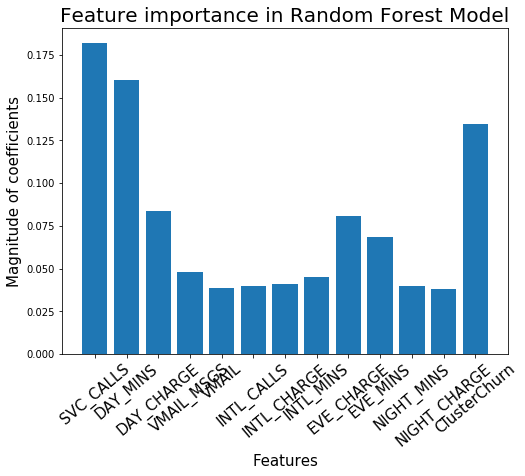

In [31]:
%local

import matplotlib.pyplot as plt
import numpy as np

features = ["SVC_CALLS", "DAY_MINS", "DAY_CHARGE", "VMAIL_MSGS", "VMAIL", "INTL_CALLS", "INTL_CHARGE", "INTL_MINS", "EVE_CHARGE", "EVE_MINS", "NIGHT_MINS", "NIGHT_CHARGE", "ClusterChurn"]
coeffs = [0.18178811184798255,0.16012024813703055,0.0838730648127356,0.04829091633062102,0.038785791711073075,0.03954393003297476,0.04112787441993293,0.045218720519418075,0.08050873268287183,0.06845799924702964,0.03970568743887793,0.037886804314506035,0.1346921185049461]

ax, fig=plt.subplots(figsize=(8,6))
index = np.arange(len(features))
plt.bar(index, coeffs)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Magnitude of coefficients', fontsize=15)
plt.xticks(index, features, fontsize=15, rotation=40)
plt.title('Feature importance in Random Forest Model', fontsize=20)
plt.show()

In [32]:
# Define your model
gbt = GBTClassifier(maxDepth=best_gbt["maxDepth"], maxBins=best_gbt["maxBins"], stepSize=best_gbt["stepSize"])
                    
# Fit the model on training set
gbtModel = gbt.fit(labeled_train)

print(gbtModel.featureImportances)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(13,[0,1,3,4,5,6,8,9,10,11,12],[0.06714599590652838,0.23636783948027026,0.09613841225316823,0.04088875720039956,0.0695613407908431,0.10131683893384555,0.1910738766434666,0.023698197994991725,0.06498665271484957,0.020281824092990192,0.08854026398864706])

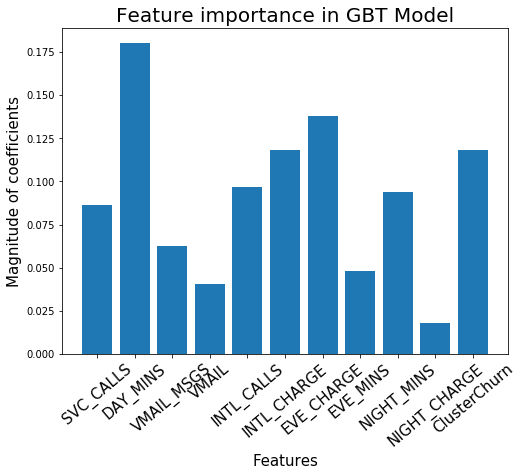

In [33]:
%local

features = ["SVC_CALLS", "DAY_MINS", "VMAIL_MSGS", "VMAIL", "INTL_CALLS", "INTL_CHARGE", "EVE_CHARGE", "EVE_MINS", "NIGHT_MINS", "NIGHT_CHARGE", "ClusterChurn"]
coeffs = [0.08604907727746372,0.17990409496699397,0.062380698472049766,0.040737334334920466,0.09673148702932027,0.11831440107351968,0.13769400258490144,0.04801852764059272,0.09398745422993804,0.017899850163581348,0.11828307222671867]

ax, fig=plt.subplots(figsize=(8,6))
index = np.arange(len(features))
plt.bar(index, coeffs)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Magnitude of coefficients', fontsize=15)
plt.xticks(index, features, fontsize=15, rotation=40)
plt.title('Feature importance in GBT Model', fontsize=20)
plt.show()

Differs qualitatively and quantitatively from the previous model! GBT does not use all features, in contrast to random forest.

## 5. Assess your model performance on the test set

See what is the final perfomance of your tuned model on unseen data.

In [34]:
# Prepare the test set
assembled_test = assembler_13.transform(prepared_test)

# Select only the label and features columns
labeled_test = assembled_test.select(assembled_test["features"], assembled_test["CHURN"].alias("label"))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

__Logistic regression__

In [35]:
# Make predictions on test set
pred_test_lr = lrModel.transform(labeled_test)

# Compute the accuracy on the test set
print("Test Accuracy: %.3f" %  evaluator_acc.evaluate(pred_test_lr))

# Confusion matrix
(tn, fp, fn, tp)=confusion_matrix(pred_test_lr)
# Confusion matrix in format [[tp, fn], [fp, tn]]
print("Confusion matrix: ")
print(np.array([[("tp: "+str(tp)), ("fn: "+str(fn))], [("fp: "+str(fp)), ("tn: "+str(tn))]]))

# FNR
print("Recall: %.3f" %recall(tp, fn))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Test Accuracy: 0.884
Confusion matrix: 
[['tp: 23' 'fn: 49']
 ['fp: 11' 'tn: 434']]
Recall: 0.319

__Random Forest__

In [36]:
# Make predictions on test set
pred_test_rf = rfModel.transform(labeled_test)

# Compute the accuracy on the test set
print("Test Accuracy = %.3f" %evaluator_acc.evaluate(pred_test_rf))

# Confusion matrix
(tn, fp, fn, tp)=confusion_matrix(pred_test_rf)
# Confusion matrix in format [[tp, fn], [fp, tn]]
print("Confusion matrix: ")
print(np.array([[("tp: "+str(tp)), ("fn: "+str(fn))], [("fp: "+str(fp)), ("tn: "+str(tn))]]))

# Recall
print("recall: %.3f" %recall(tp, fn))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Test Accuracy = 0.928
Confusion matrix: 
[['tp: 45' 'fn: 27']
 ['fp: 10' 'tn: 435']]
recall: 0.625

__GBT__

In [37]:
# Make predictions on test set
pred_test_gbt = gbtModel.transform(labeled_test)

# Compute the accuracy on the test set
print("Test Accuracy = %.3f" %evaluator_acc.evaluate(pred_test_gbt))

# Confusion matrix
(tn, fp, fn, tp)=confusion_matrix(pred_test_gbt)
# Confusion matrix in format [[tp, fn], [fp, tn]]
print("Confusion matrix: ")
print(np.array([[("tp: "+str(tp)), ("fn: "+str(fn))], [("fp: "+str(fp)), ("tn: "+str(tn))]]))

# Recall
print("recall: %.3f" %recall(tp, fn))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Test Accuracy = 0.915
Confusion matrix: 
[['tp: 41' 'fn: 31']
 ['fp: 13' 'tn: 432']]
recall: 0.569

__Model choice__ 

* Logistic regression 

It does clearly not perform as well as the ensemble models. 

Comparison between Random Forest and GBT :

* Random Forest 

Execution takes only a couple of seconds. Performs well: high accuracy and recall.

* GBT

Hyperparameter tuning can take up to a few minutes. Highest recall by far but partly at the cost of accuracy. However our main concern is recall and accuracy is still acceptable.
__=> We keep this model.__

__Gains graph__

In [38]:
pred_test_rf.createOrReplaceTempView("pred_test_rf")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [39]:
%%sql -o pred_test_rf --maxrows -1
SELECT * FROM pred_test_rf

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

/Users/eva.feillet/anaconda3/lib/python3.7/site-packages/autovizwidget/widget/utils.py:50: FutureWarning:

A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.



Output()

In [40]:
pred_test_lr.createOrReplaceTempView("pred_test_lr")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [41]:
%%sql -o pred_test_lr --maxrows -1
SELECT * FROM pred_test_lr

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Output()

In [42]:
pred_test_gbt.createOrReplaceTempView("pred_test_gbt")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [43]:
%%sql -o pred_test_gbt --maxrows -1
SELECT * FROM pred_test_gbt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Output()

In [44]:
%local 

def gainChart(pred_test):
    
    # Extract the relevant data

    # Predicted proba that label is 1
    proba0 = [x["values"][0] for x in pred_test["probability"]]
    pred_test["proba0"] = pd.Series(proba0)
    sorted_pred_test = pred_test.sort_values(by="proba0").drop(["features", "rawPrediction", "probability"], axis=1)

    sorted_pred_test.head(5)

    # Reset index
    sorted_pred_test_bis = sorted_pred_test.reset_index(drop=True)
    n = len(sorted_pred_test_bis)

    # Add cumulated count for #customers and cumulated frequency for %churners

    #Initialize columns
    sorted_pred_test_bis["#Customers"] = pd.Series([0 for x in range(n)])
    #sorted_pred_test_bis["#predChurners"] = pd.Series([0 for x in range(n)])
    sorted_pred_test_bis["#trueChurners"] = pd.Series([0 for x in range(n)])

    # case i = 0
    sorted_pred_test_bis["#Customers"][0] = 1
    #sorted_pred_test_bis["#predChurners"][0] = sorted_pred_test_bis["prediction"][0]
    sorted_pred_test_bis["#trueChurners"][0] = sorted_pred_test_bis["label"][0]

    # case i>0
    for i in range(1,n):
        sorted_pred_test_bis["#Customers"][i] = i+1
        #sorted_pred_test_bis["#predChurners"][i] = sorted_pred_test_bis["#predChurners"][i-1] + sorted_pred_test_bis["prediction"][i]
        sorted_pred_test_bis["#trueChurners"][i] = sorted_pred_test_bis["#trueChurners"][i-1] + sorted_pred_test_bis["label"][i]

    # Counters as percentages
    m = sum(sorted_pred_test_bis["label"])
    #sorted_pred_test_bis["#predChurners"]/= m  
    sorted_pred_test_bis["#trueChurners"]/= m
    sorted_pred_test_bis["#Customers"] /= n

    
    ## Extract x and y for plot 

    x = sorted_pred_test_bis["#Customers"].values.tolist()
    #y = [sorted_pred_test_bis["#trueChurners"].values.tolist(), sorted_pred_test_bis["#predChurners"].values.tolist()]
    y = sorted_pred_test_bis["#trueChurners"].values.tolist()
    
    return(x,y)

In [45]:
%local
import warnings
warnings.filterwarnings("ignore")

from multiprocessing.dummy import Pool as ThreadPool
# Parallelize tasks
def calculateParallel_xy(dfList, threads=2):
    pool = ThreadPool(threads)
    results = pool.map(gainChart, dfList)
    pool.close()
    pool.join()
    return results

# Compute values
dfList = [pred_test_lr, pred_test_rf, pred_test_gbt]
xy_list = calculateParallel_xy(dfList, 4)
[(x_lr, y_lr), (x_rf, y_rf), (x_gbt, y_gbt)] = xy_list

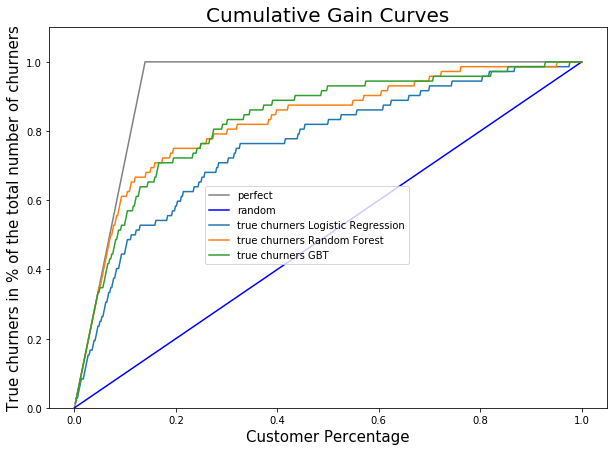

In [46]:
%local

## Plot all the curves on the same graph

m = sum(pred_test_lr["label"])
n = len(pred_test_lr)

ax, fig=plt.subplots(figsize=(10,7))
    
x_random = [0,1]
y_random = [0,1]

x_perfect = [0,m/n,1]
y_perfect = [0,1,1]

plt.ylim((0, 1.1)) 

plt.plot(x_perfect, y_perfect, color = 'grey', label = "perfect")
plt.plot(x_random, y_random, color = 'b', label = "random")

plt.plot(x_lr, y_lr, label="true churners Logistic Regression")
plt.plot(x_rf, y_rf, label="true churners Random Forest")
plt.plot(x_gbt, y_gbt, label="true churners GBT")
    
    
plt.xlabel('Customer Percentage', fontsize=15)
plt.ylabel('True churners in % of the total number of churners', fontsize=15)
ax.legend(loc='center')
plt.title('Cumulative Gain Curves', fontsize=20)

plt.show()    

If we target 30 % of the customers which are the most likely to be churners, we are able to reach over 80% of all real churners using the model obtained with GBT.

## 6. Save the results for deployment

Optional : if you want to take a final look at your models' parameters before saving them.

In [47]:
#print("KMeans parameters:\n" + kmeans.explainParams() + "\n")
#print("Logistic Regression parameters:\n" + logReg.explainParams() + "\n")
#print("Random Forest parameters:\n" + rf.explainParams() + "\n")
#print("Gadient Boosted Trees parameters:\n" + gbt.explainParams() + "\n")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

__Method 1 : Extract parameter map__

First, save the parameter map of each model. Then, create a new model and use algo.fit(training_set, saved_param). Here is an example with KMeans.

In [48]:
# Example with kmeans 

# Extract parameter map
kmeansParamMap = clusterModel.extractParamMap()
print("KMeans Model was fit using parameters: ")
print(kmeansParamMap)
# Define a new model with the same parameter map
kmeans2 = kmeans.fit(train_12, kmeansParamMap)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

KMeans Model was fit using parameters: 
{Param(parent='KMeans_41dda2e25087f3f5040c', name='featuresCol', doc='features column name'): 'features', Param(parent='KMeans_41dda2e25087f3f5040c', name='initMode', doc="The initialization algorithm. Supported options: 'random' and 'k-means||'."): 'k-means||', Param(parent='KMeans_41dda2e25087f3f5040c', name='initSteps', doc='The number of steps for k-means|| initialization mode. Must be > 0.'): 2, Param(parent='KMeans_41dda2e25087f3f5040c', name='k', doc='The number of clusters to create. Must be > 1.'): 15, Param(parent='KMeans_41dda2e25087f3f5040c', name='maxIter', doc='maximum number of iterations (>= 0)'): 20, Param(parent='KMeans_41dda2e25087f3f5040c', name='predictionCol', doc='prediction column name'): 'prediction', Param(parent='KMeans_41dda2e25087f3f5040c', name='seed', doc='random seed'): 1, Param(parent='KMeans_41dda2e25087f3f5040c', name='tol', doc='the convergence tolerance for iterative algorithms (>= 0)'): 0.0001}

However this is not the most practical way of saving your models. Let's save them directly as separate files.

__Method 2 : Save models as files__

In [50]:
# just use model.save("path") if there is no name conflict
# feel free to adapt the path 
clusterModel.write().overwrite().save("/tmp/myClusterModel")
lrModel.write().overwrite().save("/tmp/myLogRegModel")
rfModel.write().overwrite().save("/tmp/myRFModel")
gbtModel.write().overwrite().save("/tmp/myGBTModel")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## What you've learned

Congratulations!

Through this notebook, you've learned how to:

* use PySpark for a classic workflow, from data preparation to model assessment
* build models using both supervised and unsupervised learning
* compute and visualize useful indicators in order to evaluate a model
* save a model for future use.

____
## Authors

Eva Feillet - ML intern, IBM Cloud and Cognitive Software, IBM Lab in Böbligen, Germany